In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_csv('application_clean.csv')

## Train Test Split

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
RSEED = 101

In [5]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED, stratify=y)

In [6]:
df_train = pd.concat([y_train, X_train], axis=1)

In [7]:
from sklearn.utils import resample

df_0 = df_train[df_train.target==0]
df_1 = df_train[df_train.target==1]

df_0d2 = resample(df_0, replace=False, n_samples=50000, random_state=5)
df_1u2 = resample(df_1, replace=True, n_samples=50000, random_state=5)
df_b = pd.concat([df_0d2, df_1u2])

df_train = df_b.copy()

X_train = df_train.drop('target', axis=1)
y_train = df_train['target']

## Fill Missing Values

In [75]:
from sklearn.preprocessing import MinMaxScaler, Imputer

imputer = Imputer(strategy = 'median')

scaler = MinMaxScaler(feature_range = (0, 1))

imputer.fit(X_train)

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/Users/lennartjunge/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## AdaBoost

In [76]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)
predictions = ada.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix for AdaBoost Classifier')

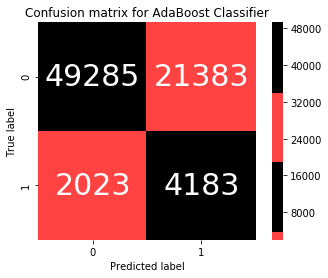

In [98]:
from sklearn.metrics import confusion_matrix

colors = ['k', '#FF4343']
colors_r = ['#FF4343', 'k', '#FF4343', 'k']

plt.figure()
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, annot_kws={"size":30}, cmap=colors_r, center=19000, square=True, fmt='.0f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for AdaBoost Classifier')

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     70668
           1       0.16      0.67      0.26      6206

    accuracy                           0.70     76874
   macro avg       0.56      0.69      0.54     76874
weighted avg       0.90      0.70      0.76     76874



In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predictions)

0.6857206117265813

## Hyperparameter Tuning via Randomized Search

### Based on smaller Sample

In [43]:
df_sample = df.sample(20000)

In [44]:
X_sample = df_sample.drop('target', axis=1)
y_sample = df_sample['target']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sample, y_sample, test_size=0.25, random_state=RSEED, stratify=y_sample)

In [45]:
df_train_s = pd.concat([y_train_s, X_train_s], axis=1)

In [46]:
from sklearn.utils import resample

df_0_s = df_train_s[df_train_s.target==0]
df_1_s = df_train_s[df_train_s.target==1]

df_0d2_s = resample(df_0_s, replace=False, n_samples=10000, random_state=5)
df_1u2_s = resample(df_1_s, replace=True, n_samples=10000, random_state=5)
df_b_s = pd.concat([df_0d2_s, df_1u2_s])

df_train_s = df_b_s.copy()

X_train_s = df_train_s.drop('target', axis=1)
y_train_s = df_train_s['target']

In [47]:
imputer = Imputer(strategy = 'median')

scaler = MinMaxScaler(feature_range = (0, 1))

imputer.fit(X_train_s)

X_train_s = imputer.transform(X_train_s)
X_test_s = imputer.transform(X_test_s)

scaler.fit(X_train_s)
X_train_s = scaler.transform(X_train_s)
X_test_s = scaler.transform(X_test_s)

/Users/lennartjunge/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.tree import DecisionTreeClassifier

# TODO: Initialize the classifier
estimator = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=RSEED)

# TODO: Create the parameters list you wish to tune
param_grid = {'n_estimators' : [100, 200], 
              'learning_rate' : [1., 5],
              'base_estimator__min_samples_split' : np.arange(6, 12, 2),
              'base_estimator__max_depth' : np.arange(1, 4, 1)
             }

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_search = RandomizedSearchCV(estimator, param_grid, scoring=scorer, n_jobs = -1,
                                cv = 3, n_iter = 10, verbose = 1, random_state=RSEED)

# TODO: Fit the grid search object to the training data and find the optimal parameters
gs_fit = grid_search.fit(X_train_s, y_train_s)

# Get the estimator
gs_fit.best_estimator_

# Make predictions using the unoptimized and model
#predictions = (clf.fit(X_train_s, y_train_s)).predict(X_test_s)
#best_predictions = best_clf.predict(X_test_s)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.0min finished


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=6,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

### Best Model

In [125]:
ada_best = AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=6,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                                                         splitter='best'),
                   learning_rate=1.0, n_estimators=200, random_state=101)
ada_best.fit(X_train, y_train)
predictions = ada_best.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix for AdaBoost Classifier')

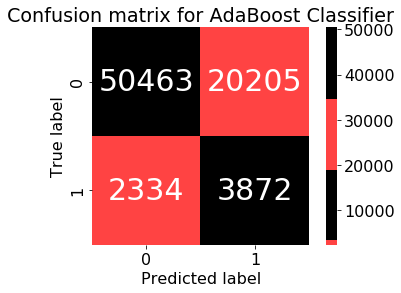

In [126]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('font', size=16)

colors = ['k', '#FF4343']
colors_r = ['#FF4343', 'k', '#FF4343', 'k']
plt.figure()
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, annot_kws={"size":30}, cmap=colors_r, center=19100, square=True, fmt='.0f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for AdaBoost Classifier')

In [127]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     70668
           1       0.16      0.62      0.26      6206

    accuracy                           0.71     76874
   macro avg       0.56      0.67      0.54     76874
weighted avg       0.89      0.71      0.77     76874



### Cross Validation

In [130]:
from sklearn.model_selection import cross_val_score
recall = cross_val_score(ada_best, X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)

Recall 0.73284 [0.7373 0.7356 0.7288 0.7339 0.7286]


## Feature Importance

In [77]:
X = pd.DataFrame(X)
cols = list(df.columns.values)
cols.remove('target')
X.columns = cols

In [114]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X.columns.values[indices[:7]]
    values = importances[indices][:7]

    # Creat the plot
    fig = plt.figure(figsize = (15,8))
    plt.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(7), values, width = 0.5, align="center", color = '#FF4343', \
          label = "Feature Weight")
    plt.bar(np.arange(7) - 0.3, np.cumsum(values), width = 0.5, align = "center", color = 'k', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns, rotation=70)
    plt.xlim((-0.5, 6.5))
    plt.ylabel("Weight", fontsize = 16)
    plt.xlabel("Feature", fontsize = 16)
    
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('font', size=16)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

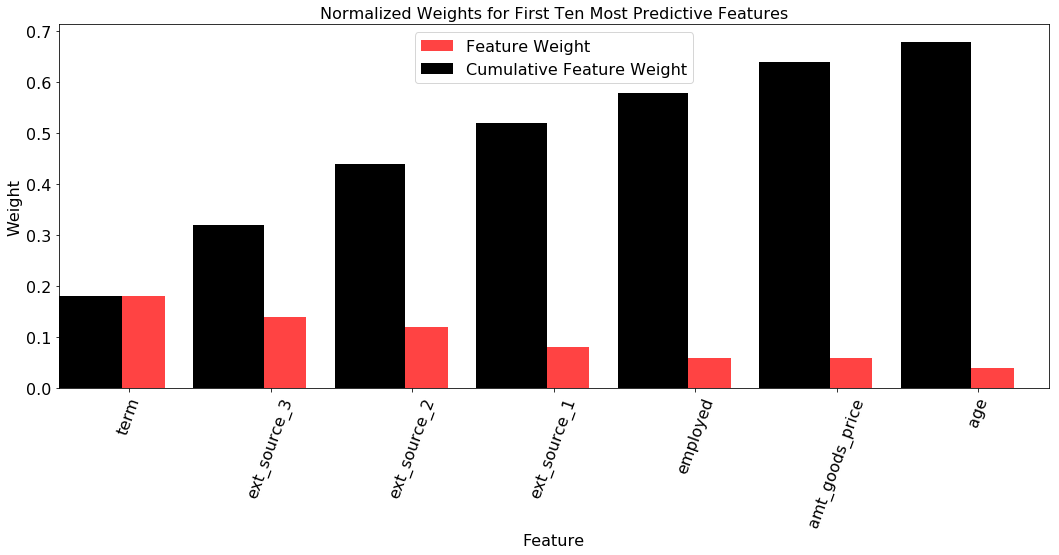

In [115]:
# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier().fit(X_train,y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)